In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp, trapezoid
%matplotlib notebook

*This is an example from this paper <a href='https://arxiv.org/abs/1309.7769'>[Causality detection and turbulence in fusion plasmas]<a>

The following code is the practice of implimenting the [transfer entropy] via the solution of [coupled Van der Pol oscillators]. 

The [coupled Van der Pol oscillators] are solved via [scipy.integrate.solve_ivp]. 

The [transfer entropy] is calculated with the [function] that is encoded in the later section. 

Similar to the paper's section 2.2, the code consists of [solving the oscillators], [calculating the transfer entropy matrix], [stability of the transfer entropy], [net flow of transfer entropy for different $\alpha$ and $\beta$].
    
*Please refer to the paper to know the [symbols] and the [mathematical expression].

# Coupled Van der Pol oscillators 
$\frac{\partial x_i}{\partial t} = y_i$ 

$\frac{\partial y_i}{\partial t} = \left[ \epsilon_i - \left( x_i + \sum_j \kappa_{ij} x_j \right)^2 \right] y_i - \left( x_i  + \sum_j \kappa_{ij} x_j\right)$

For, $\epsilon = (1, 1.1)$ and $\kappa = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} = \begin{bmatrix} \kappa_{11} & \kappa_{12} \\ \kappa_{21} & \kappa_{22} \end{bmatrix}$

Hence, the [Van der Pol oscillators] for this case will be expressed as: 

$\frac{\partial x_1}{\partial t} = y_1$ 

$\frac{\partial y_1}{\partial t} = \left[ 1.0 - \left( x_1 + x_2 \right)^2 \right] y_1 - \left( x_1 + x_2 \right)$

$\frac{\partial x_2}{\partial t} = y_2$ 

$\frac{\partial y_2}{\partial t} = \left[ 1.1 - \left( x_2 \right)^2 \right] y_2 - \left( x_2 \right)$

<IPython.core.display.Javascript object>


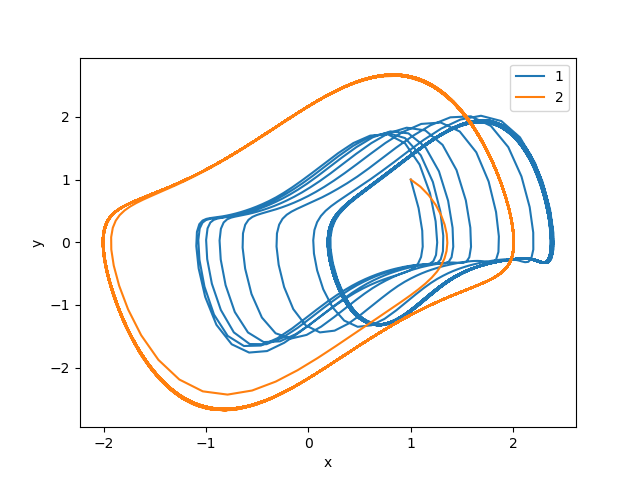

<IPython.core.display.Javascript object>


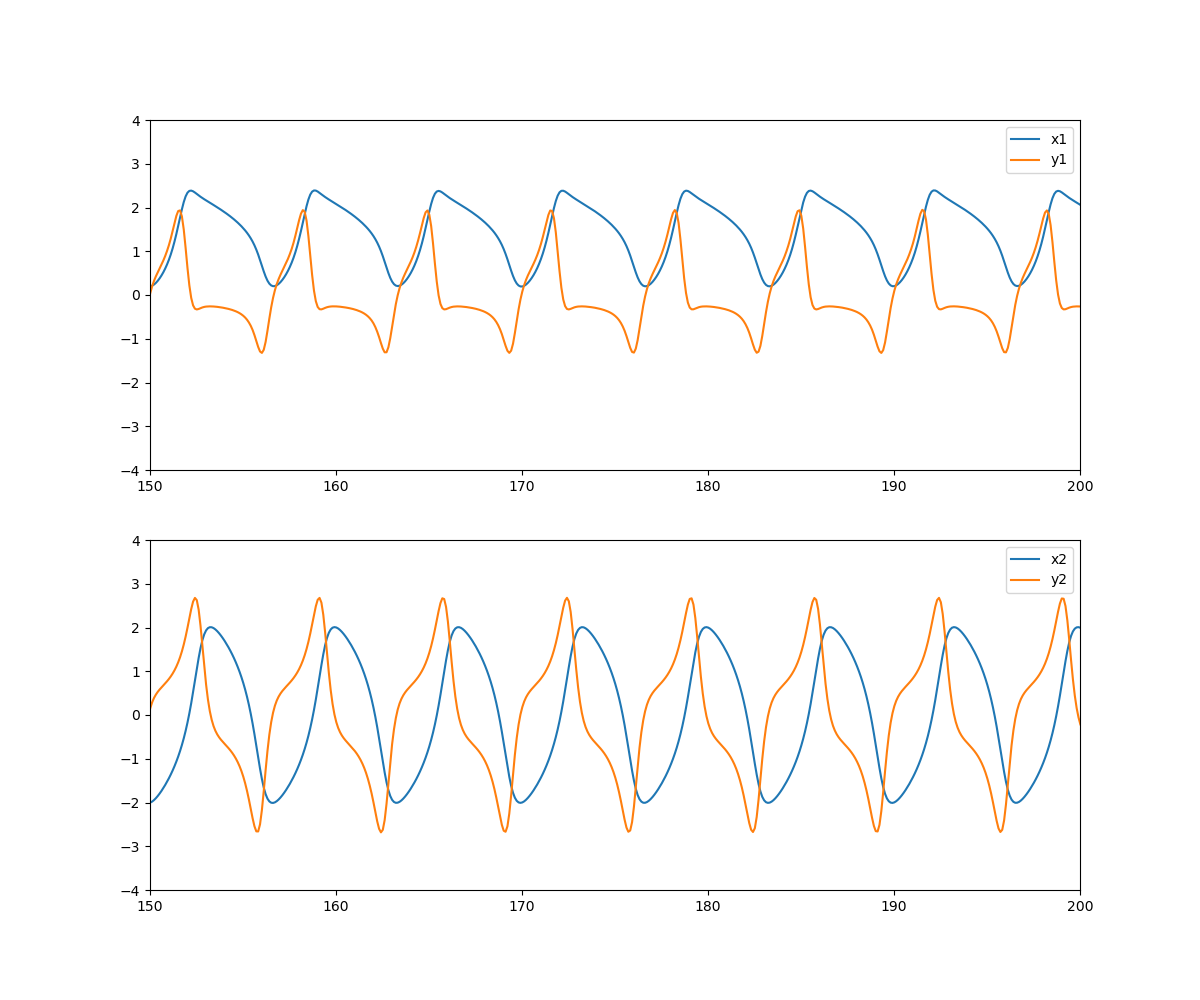

In [2]:
def vdp(t, z):
    x1, y1, x2, y2 = z
    dx1dt = y1 
    dy1dt = (1.1 - (x1 + 1.0*x2)**2)*y1 - (x1 + 1.0*x2) 
    dx2dt = y2 
    dy2dt = (1.0 - (x2 + 0.0*x2)**2)*y2 - (x2 + 0.0*x2)
    return dx1dt, dy1dt, dx2dt, dy2dt 

t = np.linspace(0, 1000, 10_000)
sol = solve_ivp(vdp, [np.min(t), np.max(t)], [1, 1, 1, 1], method='RK45', t_eval=t)

plt.figure()
plt.plot(sol.y[0], sol.y[1], label='1')
plt.plot(sol.y[2], sol.y[3], label='2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(sol.t, sol.y[0], label='x1')
ax[0].plot(sol.t, sol.y[1], label='y1')
ax[0].legend(loc='best')
ax[0].set_xlim(150, 200)
ax[0].set_ylim(-4, 4)

ax[1].plot(sol.t, sol.y[2], label='x2')
ax[1].plot(sol.t, sol.y[3], label='y2')
ax[1].legend(loc='best')
ax[1].set_xlim(150, 200)
ax[1].set_ylim(-4, 4)
plt.show()

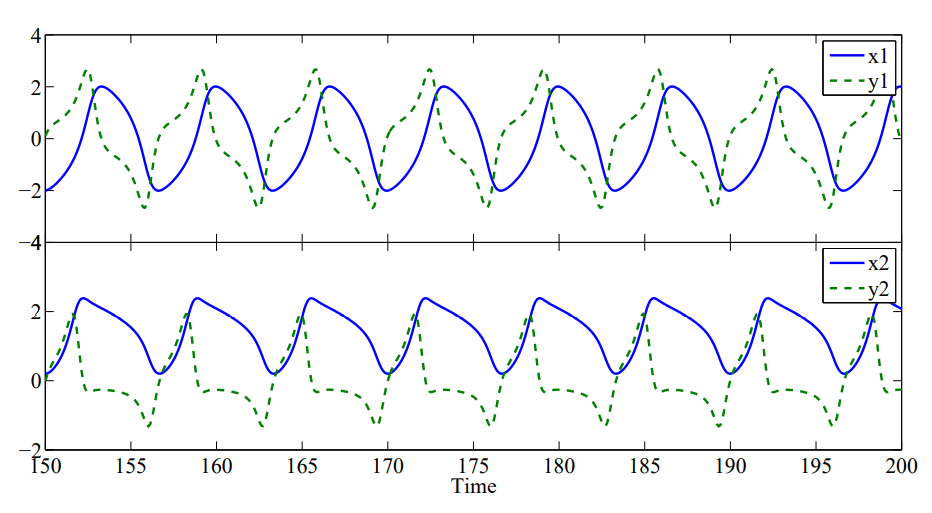

## Based on the comparison between the paper, it seems like the (x1 is x2) and (y1 is y2). Hence, the consequence part will do the swapping. 

The [transfer entropy, $T_{Y \rightarrow X}$] is defined as: 

$T_{Y \rightarrow X} = \sum p\left( x_{n+1}, x_{n}^{(k)}, y_{n}^{(l)} \right) \log_{2} \frac{p\left( x_{n+1}, x_{n}^{(k)}, y_{n}^{(l)} \right) p\left( x_{n}^{(k)} \right)}{p\left( x_{n}^{(k)}, y_{n}^{(l)} \right) p\left( x_{n+1}, x_{n}^{(k)} \right)}$

In [3]:
def entro_transfer(source, target, size, alpha):
    new_target = target[alpha+1:]
    old_target = target[:-1-alpha]
    old_source = source[:-1-alpha]
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_source, old_target]).T, density=True, bins=(size))
    pdf_margi, _ = np.histogramdd(np.array([old_target]).T, density=True, bins=(size))
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    ds_old = edges_all[1][1] - edges_all[1][0]
    dt_old = edges_all[2][1] - edges_all[2][0]
    
    data=[]
    for i in range(0, pdf_all.shape[0], 1): #new target index
        for j in range(0, pdf_all.shape[1], 1): #old source index
            for k in range(0, pdf_all.shape[2], 1): #old target index
                temp = (pdf_all[i, j, k] * pdf_margi[k])/(pdf_joint_old[k, j] * pdf_joint_new[i, k])
                temp_log = np.log2(temp)
                log = np.nan_to_num(temp_log, nan=0.0, neginf=0.0, posinf=0.0)
                
                data.append(pdf_all[i, j, k] * log)
                
    data = np.array(data)
    sol = np.sum(data * (dt_new * ds_old * dt_old)) #NOTE: the histogram gives the pdf NOTE the pmf
    
    return sol

###Alternative way of computing [transfer entropy]###
def cal_transfer(source, target, size, alpha):
    new_target = target[alpha+1:]
    old_target = target[:-1-alpha]
    old_source = source[:-1-alpha]
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size))
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size)
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

In [4]:
x2 = sol.y[0]
y2 = sol.y[1]
x1 = sol.y[2]
y1 = sol.y[3]

###calculating the [net transfer entropy] matrix###
start_time = 100.1 #start time of the series
start = np.where((sol.t < start_time) & (sol.t > start_time-0.1))[0][0] #location of the time 
size = 3 #bin size for histogram
past = 8 #number of point before the current time

x1n = x1[start:]
x2n = x2[start:]
y1n = y1[start:]
y2n = y2[start:]

series = np.array([x1n, y1n, x2n, y2n])
transfer_matrix = np.zeros((len(series), len(series)))

for i in range(0, len(series), 1):
    for j in range(0, len(series), 1):
        temp_trans1 = entro_transfer(series[i], series[j], size, past)
        temp_trans2 = entro_transfer(series[j], series[i], size, past)
        print(i+1, 'to', j+1, ':', temp_trans1)
        print(j+1, 'to', i+1, ':', temp_trans2)
        transfer_matrix[i, j] = (temp_trans1 - temp_trans2)
        print('1 = x1; 2 = y1; 3 = x2; 4 = y2')
        print('#'*50)

print(transfer_matrix)
print('1 = x1; 2 = y1; 3 = x2; 4 = y2')

1 to 1 : 4.318265957761851e-17
1 to 1 : 4.318265957761851e-17
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
1 to 2 : 0.6262357346126846
2 to 1 : 0.6621764929633379
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
1 to 3 : 0.27710919300384296
3 to 1 : 0.5622581549197437
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
1 to 4 : 0.6341337770267782
4 to 1 : 0.48822167420831913
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
2 to 1 : 0.6621764929633379
1 to 2 : 0.6262357346126846
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
2 to 2 : -2.9465395602880055e-17
2 to 2 : -2.9465395602880055e-17
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
2 to 3 : 0.46380896309099695
3 to 2 : 0.46147784596486113
1 = x1; 2 = y1; 3 = x2; 4 = y2
##################################################
2 to 4 : 0.341

C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:19: RuntimeWarning: invalid value encountered in double_scalars
  temp = (pdf_all[i, j, k] * pdf_margi[k])/(pdf_joint_old[k, j] * pdf_joint_new[i, k])
C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:20: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(temp)


In [5]:
####################################################################################
###[transfer entropy] for different [alpha]###
range_past = 30
transfer_matrix_series = np.zeros((range_past, len(series), len(series)))
range_t = []

for t in range(0, range_past, 1):
    past = t+1
    size = 3 
    start_time = 100.1
    start = np.where((sol.t < start_time) & (sol.t > start_time-0.1))[0][0]
    
    x1n = x1[start:]
    x2n = x2[start:]
    y1n = y1[start:]
    y2n = y2[start:]
    series = np.array([x1n, y1n, x2n, y2n])
    transfer_matrix = np.zeros((len(series), len(series)))

    for i in range(0, len(series), 1):
        for j in range(0, len(series), 1):
            temp_trans1 = entro_transfer(series[i], series[j], size, past) #transfer for i to j
            temp_trans2 = entro_transfer(series[j], series[i], size, past) #transfer for j to j
            transfer_matrix_series[t, i, j] = (temp_trans1 - temp_trans2) #calculate the transfer of [i to j] minus [j to i]
    range_t.append(past)
range_t = np.array(range_t)

C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:19: RuntimeWarning: invalid value encountered in double_scalars
  temp = (pdf_all[i, j, k] * pdf_margi[k])/(pdf_joint_old[k, j] * pdf_joint_new[i, k])
C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:20: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(temp)


<IPython.core.display.Javascript object>


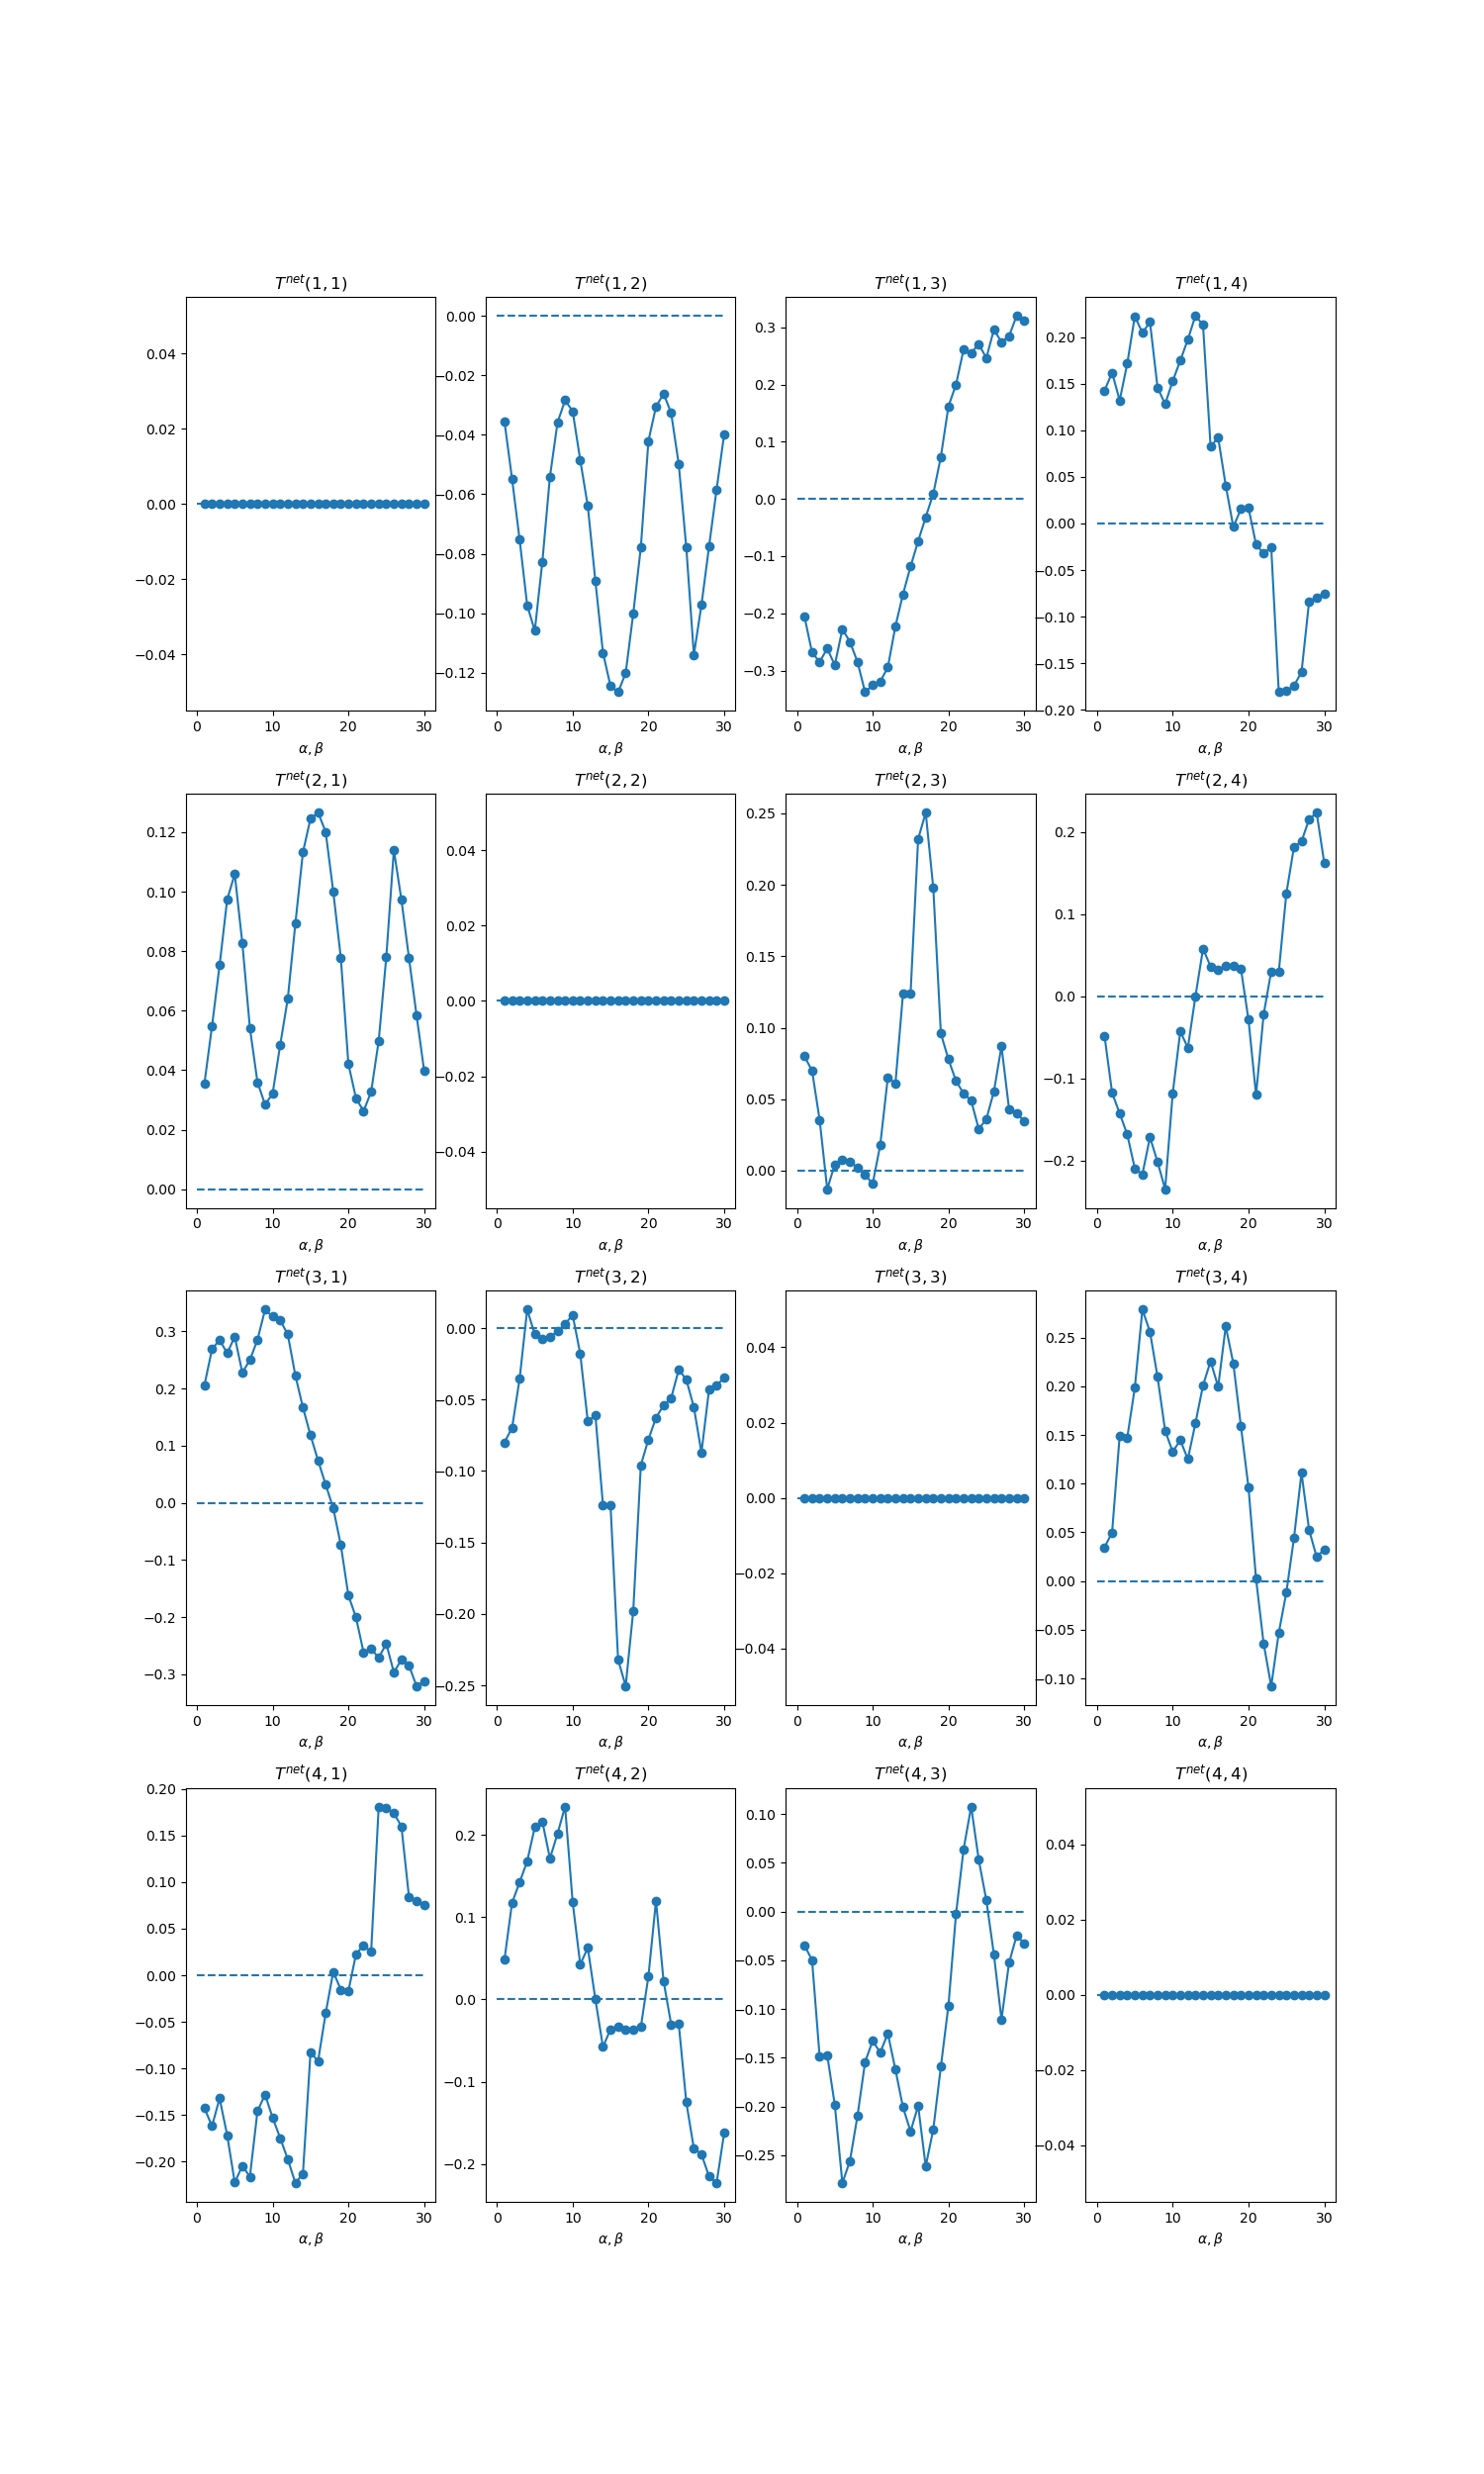

In [6]:
fig, ax = plt.subplots(len(series), len(series), figsize=(15, 25))
for i in range(len(series)):
    for j in range(len(series)):
        ax[i,j].plot(range_t, transfer_matrix_series[:,i,j], 'o-')
        ax[i,j].hlines(0, 0, np.max(range_t), linestyles='dashed')
        ax[i,j].set_xlabel(r'$\alpha, \beta$')
        title = i+1, j+1
        ax[i,j].set_title('$T^{net}$' + f'${title}$')

<IPython.core.display.Javascript object>


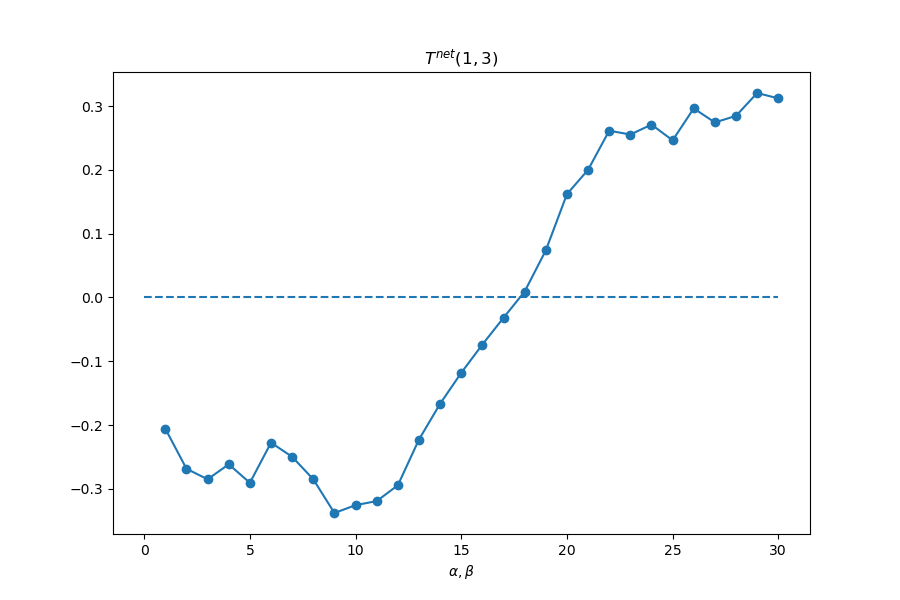

In [7]:
plt.figure(figsize=(9, 6))
plt.plot(range_t, transfer_matrix_series[:,0,2], 'o-')
plt.xlabel(r'$\alpha, \beta$')
plt.hlines(0, 0, np.max(range_t), linestyles='dashed')
plt.title('$T^{net}(1, 3)$')
plt.show()

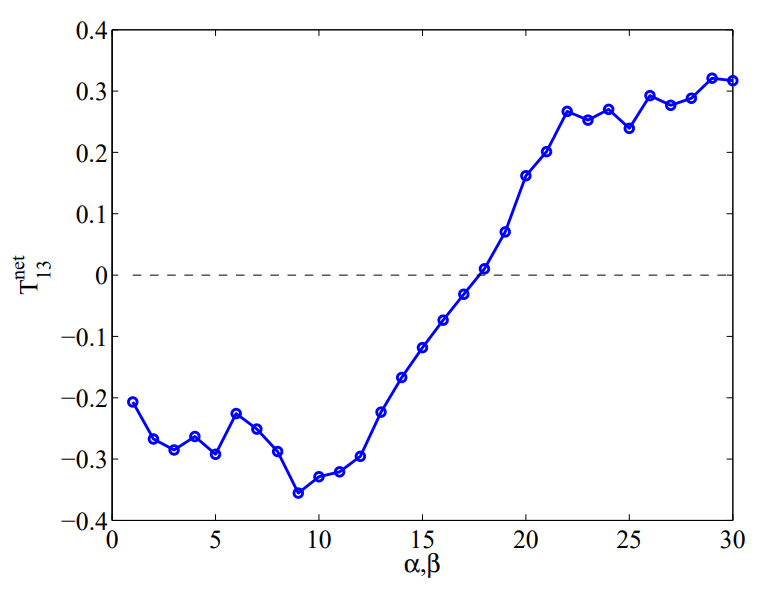

In [8]:
######################################################
x2 = sol.y[0]
y2 = sol.y[1]
x1 = sol.y[2]
y1 = sol.y[3]

start_time = 100.1 #start time of the series
start = np.where((sol.t < start_time) & (sol.t > start_time-0.1))[0][0] #location of the time 
size = 3 #bin size for histogram
past = 8 #number of point before the current time


data_list = {}
series = np.array([x1, y1, x2, y2])

for i in range(0, len(series), 1):
    for j in range(0, len(series), 1):
        entro_list = []
        time_list = []
        for t in range(start, len(sol.t), 100):
            x1n = x1[start:t]
            x2n = x2[start:t]
            y1n = y1[start:t]
            y2n = y2[start:t]
            
            series = np.array([x1n, y1n, x2n, y2n])
            
            temp_trans = entro_transfer(series[i], series[j], size, past) 
            entro_list.append(temp_trans)
            time_list.append(t)
        entro_list = np.array(entro_list)
        data_list.update({f'{i+1} to {j+1}': entro_list})

C:\Users\choongh2\Anaconda3\lib\site-packages\numpy\lib\histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:19: RuntimeWarning: invalid value encountered in double_scalars
  temp = (pdf_all[i, j, k] * pdf_margi[k])/(pdf_joint_old[k, j] * pdf_joint_new[i, k])
C:\Users\choongh2\AppData\Local\Temp\ipykernel_2796\2168456263.py:20: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(temp)


<IPython.core.display.Javascript object>


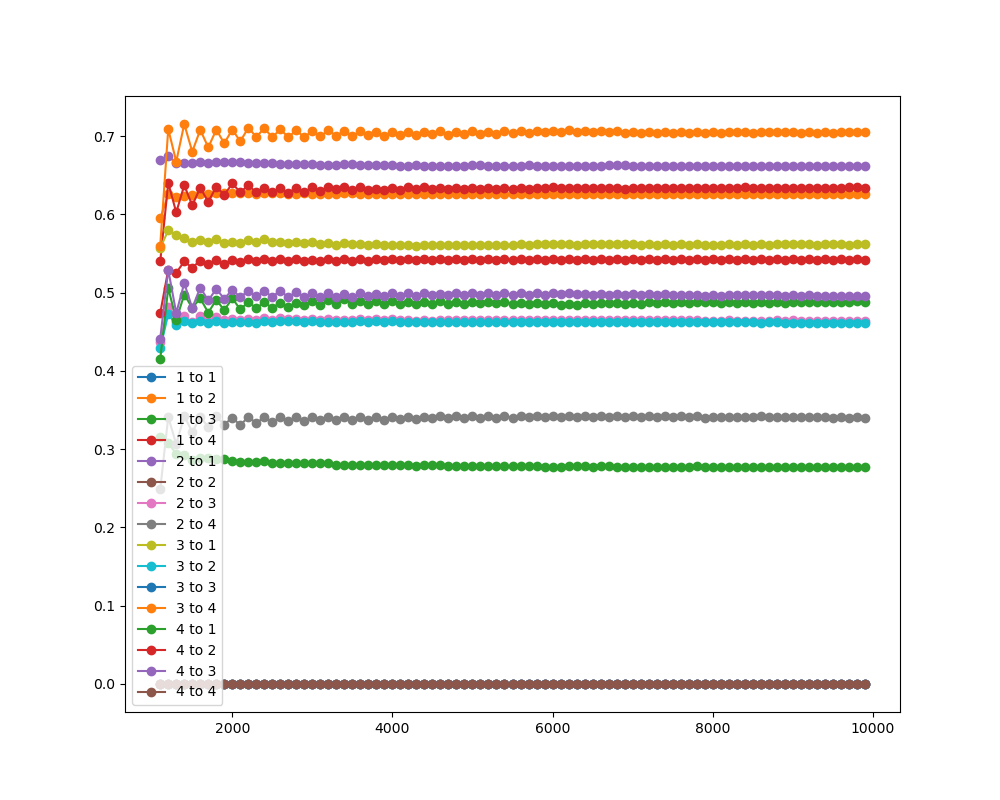

In [9]:
plt.figure(figsize=(10, 8))
for i in range(0, len(series), 1):
    for j in range(0, len(series), 1):
        plt.plot(np.delete(time_list, 0), np.delete(data_list[f'{i+1} to {j+1}'], 0), 'o-', label=f'{i+1} to {j+1}')
plt.legend(loc='best')
#plt.xscale('log')
plt.show()

<IPython.core.display.Javascript object>


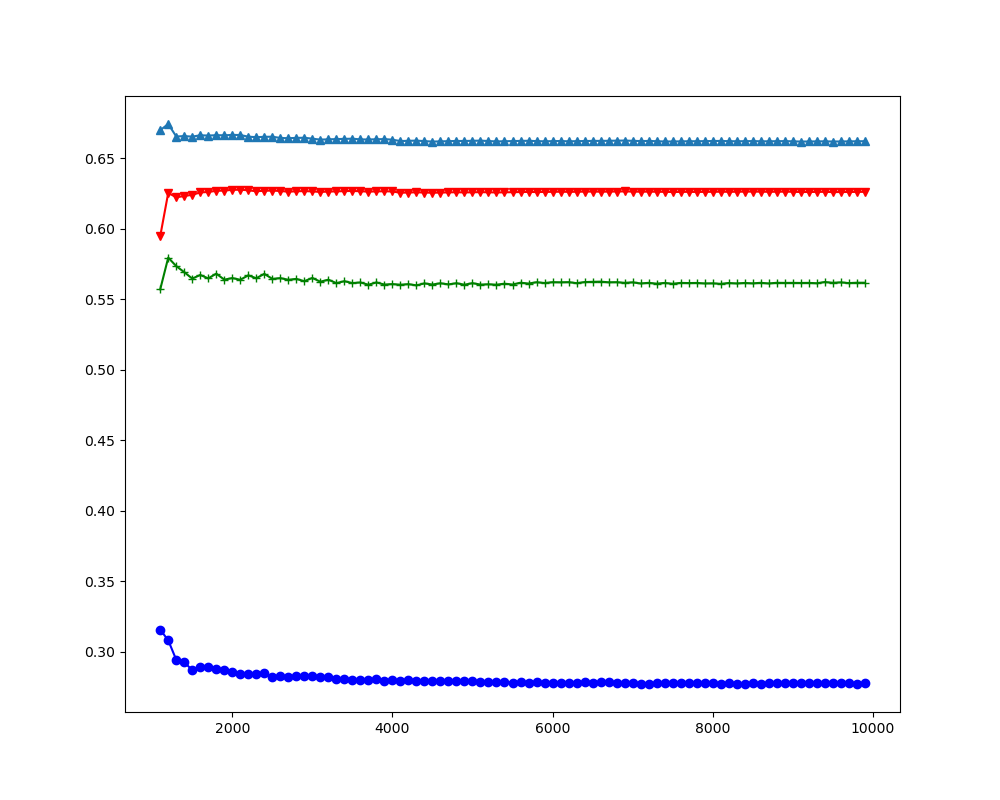

ValueError: Illegal format string "p*-"; two marker symbols

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(np.delete(time_list, 0), np.delete(data_list['1 to 3'], 0), 'bo-', label='1 to 3')
plt.plot(np.delete(time_list, 0), np.delete(data_list['3 to 1'], 0), 'g+-', label='3 to 1')
plt.plot(np.delete(time_list, 0), np.delete(data_list['1 to 2'], 0), 'rv-', label='1 to 2')
plt.plot(np.delete(time_list, 0), np.delete(data_list['2 to 1'], 0), '^-', label='2 to 1')
plt.plot(np.delete(time_list, 0), np.delete(data_list['2 to 3'], 0), 'p*-', label='2 to 3')
plt.plot(np.delete(time_list, 0), np.delete(data_list['3 to 2'], 0), 'yd-', label='3 to 2')
plt.legend(loc='best')
plt.show()

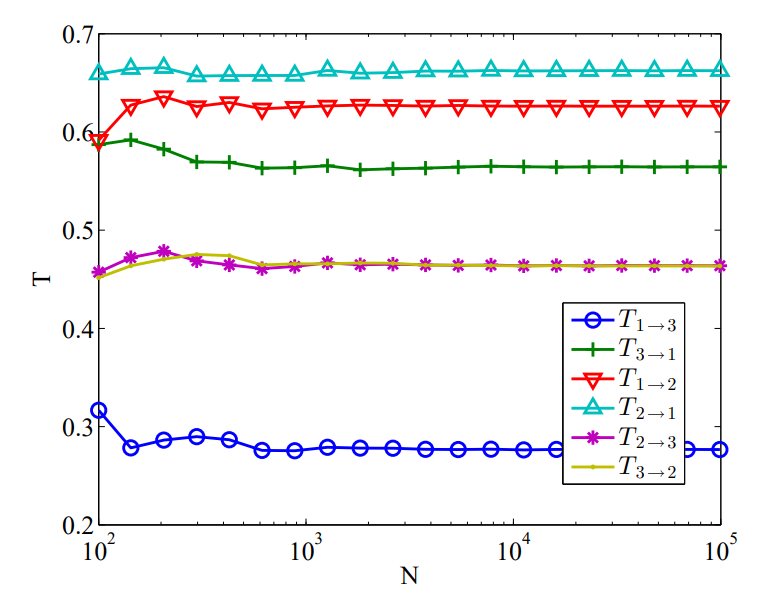